In [1]:
!wget https://raw.githubusercontent.com/amankharwal/Website-data/master/stress.csv

--2023-05-29 13:13:30--  https://raw.githubusercontent.com/amankharwal/Website-data/master/stress.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2721684 (2.6M) [text/plain]
Saving to: ‘stress.csv’

stress.csv          100%[===================>]   2.59M  --.-KB/s    in 0.07s   

2023-05-29 13:13:30 (39.5 MB/s) - ‘stress.csv’ saved [2721684/2721684]



In [11]:
import pandas as pd
import numpy as np
data = pd.read_csv("stress.csv")
data.head(3)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894


In [27]:
data.label.value_counts()

1    1488
0    1350
Name: label, dtype: int64

In [3]:
data.isnull().sum()

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64

In [4]:
import nltk
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
data["text"] = data["text"].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


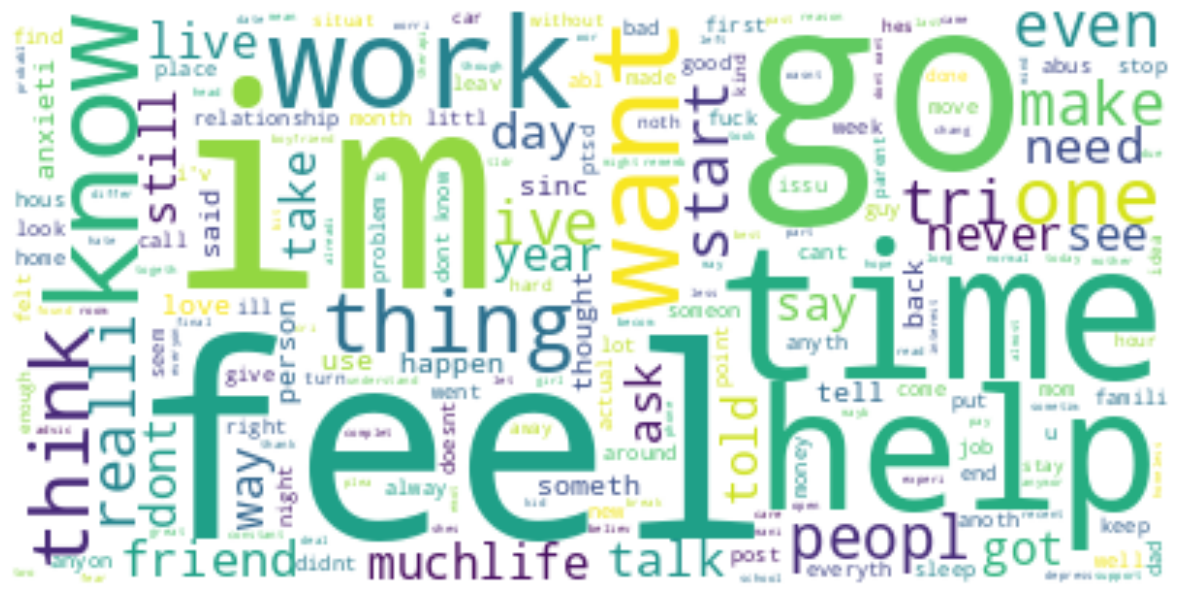

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [6]:
data["label"] = data["label"].map({0: "No Stress", 1: "Stress"})
data = data[["text", "label"]]
data.head()

,text,label
0,said felt way sugget go rest trigger ahead you...,Stress
1,hey rassist sure right place post goe im curr...,No Stress
2,mom hit newspap shock would know dont like pla...,Stress
3,met new boyfriend amaz kind sweet good student...,Stress
4,octob domest violenc awar month domest violenc...,Stress


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

x = np.array(data["text"])
y = np.array(data["label"])

cv = CountVectorizer()
X = cv.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, 
                                                test_size=0.33, 
                                                random_state=42)

In [8]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(xtrain, ytrain)

BernoulliNB()

In [9]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = model.predict(data)
print(output)

Enter a Text: I am happy
['No Stress']


In [10]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = model.predict(data)
print(output)

Enter a Text: Today work is too much.
['No Stress']


In [14]:
import pandas as pd
ypred = model.predict(xtest)
ypred= pd.Series(ypred).map({"No Stress":0, "Stress":1})

In [19]:
ytest1 = pd.Series(ytest).map({"No Stress":0, "Stress":1})

In [22]:
import sklearn.metrics as metrics
metrics.confusion_matrix(ytest1,ypred)

array([[283, 161],
       [ 76, 417]])

In [23]:
metrics.recall_score(ytest1,ypred)

0.845841784989858

In [25]:
metrics.accuracy_score(ytest1,ypred)

0.7470651013874067

In [26]:
metrics.precision_score(ytest1,ypred)

0.7214532871972318